In [94]:
from time import time
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import numpy as np
import pandas as pd
import xarray as xr

import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree
import jax.tree_util as jtu

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

from delhi_aq.my_nn import SIREN, fit, NeRF
from delhi_aq.my_utils import pool_image, get_coords_for_image

import matplotlib.pyplot as plt
from multiprocessing import Pool

In [95]:
seed = 1
aq_data = xr.open_dataset("../processed_data/delhi_cpcb_2022_cleaned.nc").to_dataframe().reset_index().set_index("time", drop=False)
aq_data = aq_data["2022"]
print(aq_data.columns)
all_stations = aq_data.dropna(subset="PM2.5").station.unique()

Index(['station', 'time', 'From Date', 'To Date', 'PM2.5', 'PM10', 'NO', 'NO2',
       'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'RH', 'WS',
       'WD', 'SR', 'BP', 'AT', 'RF', 'TOT-RF', 'latitude', 'longitude'],
      dtype='object')


/tmp/ipykernel_2075199/328091300.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  aq_data = aq_data["2022"]


In [96]:
aq_data

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,RH,WS,WD,SR,BP,AT,RF,TOT-RF,latitude,longitude
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:30:00,"Alipur, Delhi - DPCC",2022-01-01 00:30:00,2022-01-01 00:00:00,2022-01-01 01:00:00,219.50,342.75,94.73,53.95,105.95,3.78,...,79.75,NaN,205.95,4.60,999.10,6.85,0.0,0.0,28.815329,77.153010
2022-01-01 01:30:00,"Alipur, Delhi - DPCC",2022-01-01 01:30:00,2022-01-01 01:00:00,2022-01-01 02:00:00,224.50,360.25,89.30,44.70,96.60,5.50,...,82.23,NaN,206.05,4.60,998.90,6.72,0.0,0.0,28.815329,77.153010
2022-01-01 02:30:00,"Alipur, Delhi - DPCC",2022-01-01 02:30:00,2022-01-01 02:00:00,2022-01-01 03:00:00,217.00,359.00,50.08,48.20,66.45,4.30,...,82.30,NaN,205.38,4.62,998.70,6.97,0.0,0.0,28.815329,77.153010
2022-01-01 03:30:00,"Alipur, Delhi - DPCC",2022-01-01 03:30:00,2022-01-01 03:00:00,2022-01-01 04:00:00,214.25,341.50,25.18,42.80,43.30,3.70,...,82.28,NaN,206.50,4.62,998.42,6.72,0.0,0.0,28.815329,77.153010
2022-01-01 04:30:00,"Alipur, Delhi - DPCC",2022-01-01 04:30:00,2022-01-01 04:00:00,2022-01-01 05:00:00,207.50,309.67,24.17,44.75,43.50,3.38,...,82.30,NaN,211.95,4.65,998.15,6.60,0.0,0.0,28.815329,77.153010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:30:00,"Wazirpur, Delhi - DPCC",2022-12-31 19:30:00,2022-12-31 19:00:00,2022-12-31 20:00:00,146.00,249.25,28.25,41.17,69.45,80.90,...,79.28,2.17,337.45,5.70,996.12,17.12,0.0,0.0,28.699793,77.165453
2022-12-31 20:30:00,"Wazirpur, Delhi - DPCC",2022-12-31 20:30:00,2022-12-31 20:00:00,2022-12-31 21:00:00,145.00,240.75,39.43,40.73,80.27,80.00,...,80.88,1.68,345.88,5.70,996.45,16.62,0.0,0.0,28.699793,77.165453
2022-12-31 21:30:00,"Wazirpur, Delhi - DPCC",2022-12-31 21:30:00,2022-12-31 21:00:00,2022-12-31 22:00:00,153.50,241.50,47.40,41.92,89.15,86.72,...,83.45,0.95,333.67,5.70,996.65,15.90,0.0,0.0,28.699793,77.165453


In [97]:
aq_data.shape[0]/39

8760.0

In [98]:
result_df = aq_data.drop_duplicates(subset=["station"]).set_index("station")[["latitude", "longitude"]]
def load_and_process_data(station):
    # print("###############")
    # print(f"Station: {station}")
    # print("###############")
    timeseries = aq_data[aq_data["station"] == station][['time', 'PM2.5', "station"]]
    init_len = timeseries.shape[0]
    timeseries['x'] = np.linspace(-1, 1, init_len)
    timeseries.dropna(subset=["PM2.5"], inplace=True)
    final_len = timeseries.shape[0]
    missing_data_frac = 1 - final_len/init_len
    # print(f"Initial length={init_len}, Final length={final_len}, missing data frac={missing_data_frac:.2f}")
    
    timeseries = timeseries[["time", "station", "x", "PM2.5"]]
    train_val_df, test_df = train_test_split(timeseries, test_size=0.2, random_state=seed+1)
    train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=seed+2)
    # x = timeseries['x'].values.reshape(-1, 1)
    # y = timeseries['PM2.5'].values.reshape(-1, 1)
    # train_val_x_, test_x_, train_val_y_, test_y_ = train_test_split(x, y, test_size=0.2, random_state=seed+1)
    # train_x_, val_x_, train_y_, val_y_ = train_test_split(train_val_x_, train_val_y_, test_size=0.2, random_state=seed+2)
    # return train_x_, val_x_, test_x_, train_y_, val_y_, test_y_, missing_data_frac
    return train_df, val_df, test_df, timeseries
    
def run(station, gpu_id, model_name):
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    train_df, val_df, test_df, timeseries = load_and_process_data(station)
    train_x_ = train_df[["x"]].values
    train_y_ = train_df[["PM2.5"]].values
    val_x_ = val_df[["x"]].values
    val_y_ = val_df[["PM2.5"]].values
    test_x_ = test_df[["x"]].values
    test_y_ = test_df[["PM2.5"]].values
    
    x_scaler = MinMaxScaler((-1, 1))
    y_scaler = MinMaxScaler((-1, 1))
    train_x = x_scaler.fit_transform(train_x_)
    val_x = x_scaler.transform(val_x_)
    test_x = x_scaler.transform(test_x_)
    train_y = y_scaler.fit_transform(train_y_)
    val_y = y_scaler.transform(val_y_)
    test_y = y_scaler.transform(test_y_)
    # print(train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape)
    
    if model_name == "siren":
        model = SIREN(n_hidden_layer_neurons=[256, 256, 256, 256], output_shape=train_y_.shape[-1], activation_scale=30.0)
    elif model_name == "nerf-relu":
        model = NeRF(n_hidden_layer_neurons=[256, 256, 256, 256], output_shape=train_y_.shape[-1], activation="relu")
    config = {"lr": 1e-4, "batch_size":-1, "iterations":10000}
    params, old_params_history, train_losses, val_losses, test_losses = fit(jax.random.PRNGKey(seed+3), model, 
                                                                            train_x, train_y, config, val_x, val_y, test_x, test_y)
    
    # plt.plot(train_losses, label="train")
    # plt.plot(val_losses, label="val")
    # plt.plot(test_losses, label="test")
    # plt.legend();
    
    best_val_idx = jnp.argmin(val_losses)
    best_params = jtu.tree_map(lambda x: x[best_val_idx], old_params_history)
    
    pred_y = model.apply(best_params, test_x).__array__()
    pred_y_ = y_scaler.inverse_transform(pred_y)

    pred_val = model.apply(best_params, val_x).__array__()
    pred_val_ = y_scaler.inverse_transform(pred_val)
    
    pred_train = model.apply(best_params, train_x).__array__()
    pred_train_ = y_scaler.inverse_transform(pred_train)

    
    # plt.scatter(test_y_, pred_y_)
    # plt.plot([0, 500], [0, 500], color="r", linestyle="--");

    timeseries["pred_PM2.5"] = np.nan
    timeseries.loc[test_df.index, "pred_PM2.5"] = pred_y_.ravel()
    timeseries.loc[val_df.index, "pred_PM2.5"] = pred_val_.ravel()
    timeseries.loc[train_df.index, "pred_PM2.5"] = pred_train_.ravel()
    
    rmse = mean_squared_error(test_y_, pred_y_, squared=False)
    return station, rmse, timeseries, train_df, val_df, test_df

# run the above function parallely on 4 GPUs using multiprocessing
# I want to dynamically allocate GPUs as they become available

init = time()
pool = Pool(4)
results = []
for station in tqdm(all_stations[:4]):
    gpu_id = len(results) % 4
    results.append(pool.apply_async(run, args=(station, gpu_id, "siren")))
pool.close()
pool.join()

siren_results = [r.get() for r in results]
# result_df = pd.DataFrame([r.get() for r in results], columns=["station", "rmse", "missing_data_frac"]).set_index("station")
# result_df.to_csv("results/temporal_interpolation_SIREN.csv")
# pd.to_pickle(results, "results/temporal_interpolation_SIREN.pkl")
print(f"Time taken: {(time() - init)/60:.2f} mins")

100%|██████████| 4/4 [00:00<00:00, 23899.17it/s]


Time taken: 0.27 mins


## NeRF

In [99]:
result_df = aq_data.drop_duplicates(subset=["station"]).set_index("station")[["latitude", "longitude"]]

init = time()
pool = Pool(4)
results = []
for station in tqdm(all_stations[:4]):
    gpu_id = len(results) % 4
    results.append(pool.apply_async(run, args=(station, gpu_id, "nerf-relu")))
pool.close()
pool.join()

nerf_relu_results = [r.get() for r in results]
# result_df.to_csv("results/temporal_interpolation_ReLU-NN.csv")
# pd.to_pickle(results, "results/temporal_interpolation_ReLU-NN.pkl")
print(f"Time taken: {(time() - init)/60:.2f} mins")

100%|██████████| 4/4 [00:00<00:00, 29641.72it/s]


Time taken: 0.29 mins


## RF

In [104]:
def run(station):
    train_df, val_df, test_df, timeseries = load_and_process_data(station)
    train_x_ = train_df[["x"]].values
    train_y_ = train_df[["PM2.5"]].values
    val_x_ = val_df[["x"]].values
    val_y_ = val_df[["PM2.5"]].values
    test_x_ = test_df[["x"]].values
    test_y_ = test_df[["PM2.5"]].values
    
    model = RandomForestRegressor(n_estimators=1000, random_state=seed)
    model.fit(train_x_, train_y_.ravel())
    pred_y_ = model.predict(test_x_)
    pred_val_ = model.predict(val_x_)
    pred_train_ = model.predict(train_x_)
    
    timeseries["pred_PM2.5"] = np.nan
    timeseries.loc[test_df.index, "pred_PM2.5"] = pred_y_.ravel()
    timeseries.loc[val_df.index, "pred_PM2.5"] = pred_val_.ravel()
    timeseries.loc[train_df.index, "pred_PM2.5"] = pred_train_.ravel()
    
    rmse = mean_squared_error(test_y_, pred_y_, squared=False)
    return station, rmse, timeseries, train_df, val_df, test_df

init = time()
pool = Pool(4)
results = []
for station in tqdm(all_stations[:4]):
    results.append(pool.apply_async(run, args=(station,)))
pool.close()
pool.join()

rf_results = [r.get() for r in results]
# result_df = pd.DataFrame([r.get() for r in results], columns=["station", "rmse", "missing_data_frac"]).set_index("station")
# result_df.to_csv("results/temporal_interpolation_RF.csv")
print(f"Time taken: {(time() - init)/60:.2f} mins")

100%|██████████| 4/4 [00:00<00:00, 30012.91it/s]


Time taken: 0.13 mins


## GB

In [105]:
# def run(station):
#     train_x_, val_x_, test_x_, train_y_, val_y_, test_y_, missing_data_frac = load_and_process_data(station)
#     # train_val_x_ = np.concatenate([train_x_, val_x_], axis=0)
#     # train_val_y_ = np.concatenate([train_y_, val_y_], axis=0)
    
#     model = GradientBoostingRegressor(n_estimators=1000, random_state=seed)
#     model.fit(train_x_, train_y_.ravel())
#     pred_y_ = model.predict(test_x_)
    
#     rmse = mean_squared_error(test_y_, pred_y_, squared=False)
#     return station, rmse, missing_data_frac

# init = time()
# pool = Pool(32)
# results = []
# for station in tqdm(all_stations):
#     results.append(pool.apply_async(run, args=(station,)))
# pool.close()
# pool.join()

# result_df = pd.DataFrame([r.get() for r in results], columns=["station", "rmse", "missing_data_frac"]).set_index("station")
# result_df.to_csv("results/temporal_interpolation_GB.csv")
# print(f"Time taken: {(time() - init)/60:.2f} mins")

Alipur, Delhi - DPCC 20.584472866437313
Alipur, Delhi - DPCC 59.43706370600491
Alipur, Delhi - DPCC 23.626776453455406


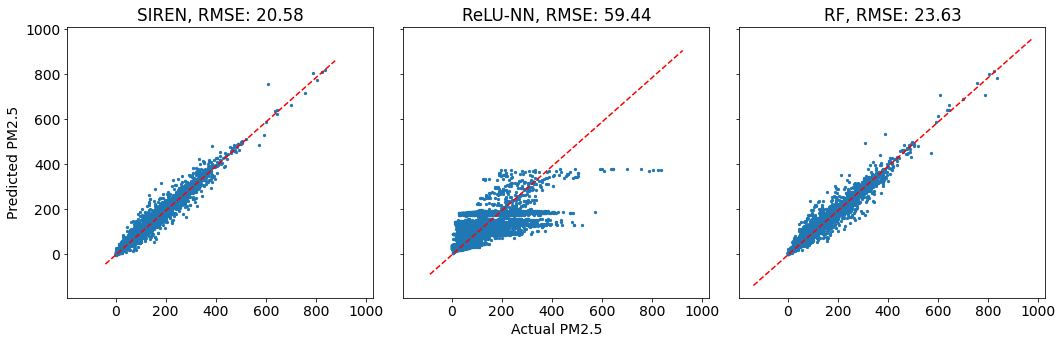

In [106]:
s_id = 0

plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for i, (result, ax, name) in enumerate(zip([siren_results, nerf_relu_results, rf_results], axes.ravel(), ["SIREN", "ReLU-NN", "RF"])):
    station, rmse, timeseries, train_df, val_df, test_df = result[s_id]
    print(station, rmse)
    before = timeseries.shape[0]
    timeseries = timeseries.dropna(subset=["pred_PM2.5"])
    after = timeseries.shape[0]
    
    ax.scatter(timeseries["PM2.5"], timeseries["pred_PM2.5"], s=5)
    ax.plot([*ax.get_xlim()], [*ax.get_ylim()], color="r", linestyle="--")
    ax.set_title(f"{name}, RMSE: {rmse:.2f}")
    if i == 1:
        ax.set_xlabel("Actual PM2.5")
    if i == 0:
        ax.set_ylabel("Predicted PM2.5")
    
plt.tight_layout()

/tmp/ipykernel_2075199/2126461559.py:8: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  timeseries = timeseries["2022-01"]


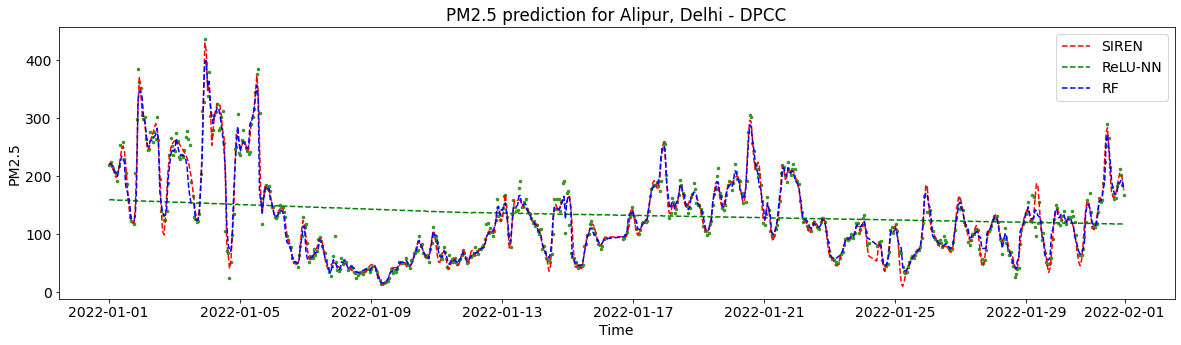

In [113]:
s_id = 0

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 1, figsize=(20, 5), sharex=True, sharey=True)
for i, (result, name, c) in enumerate(zip([siren_results, nerf_relu_results, rf_results], ["SIREN", "ReLU-NN", "RF"], ["r", "g", "b"])):
    station, rmse, timeseries, train_df, val_df, test_df = result[s_id]
    
    timeseries = timeseries["2022-01"]
    
    ax.scatter(timeseries.time, timeseries["PM2.5"], s=5)
    ax.plot(timeseries.time, timeseries["pred_PM2.5"], linestyle="--", label=name, color=c)
    
ax.set_title(f"PM2.5 prediction for {station}")
ax.legend();
ax.set_xlabel("Time")
ax.set_ylabel("PM2.5");